In [9]:
import sys
sys.path.append('/Users/ines/NLP/emergency_chatbot')  # permet d'aller au dossier parent (emergency_chatbot)
from api_chatbot.preprocessing import preprocess

In [3]:
import pandas as pd

df = pd.read_csv("/Users/ines/NLP/emergency_chatbot/data/triage_dataset.csv", encoding="utf8")

In [5]:
print(df.columns)

Index(['question', 'triage'], dtype='object')


In [7]:
print(df.head(10))

                                            question      triage
0  I am 35 years old unmarried , i was diagonized...  non-urgent
1  I have been having abdominal pain and burning ...  non-urgent
2  sir, Day before yesterday i had an oil fried i...      urgent
3  friend has a lump where their coccyx is, has b...      urgent
4  Which demographic should raise suspicion of a ...  non-urgent
5  What bacterial infection can lead to the devel...  non-urgent
6  Hi my daughter is two years old and lately she...      urgent
7  I have a large anechoic cyst in my right kidne...  non-urgent
8  What is the patella reflex and which nerve roo...  non-urgent
9  Hello doctor, I am 42 years old. I had a heart...  non-urgent


In [1]:
import pandas as pd

df = pd.read_csv("/Users/ines/NLP/emergency_chatbot/data/triage_dataset_preprocess.csv", encoding="utf8")

In [3]:
print(df.columns)
print(df.head(10))

Index(['question', 'triage', 'question_clean'], dtype='object')
                                            question      triage  \
0  I am 35 years old unmarried , i was diagonized...  non-urgent   
1  I have been having abdominal pain and burning ...  non-urgent   
2  sir, Day before yesterday i had an oil fried i...      urgent   
3  friend has a lump where their coccyx is, has b...      urgent   
4  Which demographic should raise suspicion of a ...  non-urgent   
5  What bacterial infection can lead to the devel...  non-urgent   
6  Hi my daughter is two years old and lately she...      urgent   
7  I have a large anechoic cyst in my right kidne...  non-urgent   
8  What is the patella reflex and which nerve roo...  non-urgent   
9  Hello doctor, I am 42 years old. I had a heart...  non-urgent   

                                      question_clean  
0  35 year old unmarried diagonize hepatitis b su...  
1  abdominal pain burn no relieve omeprazole bowe...  
2  sir day yesterday o

In [15]:
import re

def extract_age(text):
    if not isinstance(text, str):
        return -1

    # Mapping pour termes non numériques
    mapping = {
        'newborn': 0.1,
        'infant': 0.5,
        'toddler': 2,
        'child': 7,
        'adolescent': 15,
        'teenager': 15,
    }

    # Décades ("thirties", ...)
    decades = {
        "twenties": 25,
        "thirties": 35,
        "forties": 45,
        "fifties": 55,
        "sixties": 65,
        "seventies": 75,
        "eighties": 85,
        "nineties": 95,
    }

    # Patterns regex
    patterns = [
        r'\bI\s*am\s*(\d{1,3})\b',                                 # I am 23
        r"\bI'm\s*(\d{1,3})\b",                                    # I'm 37
        r'\bI\s*am\s*(\d{1,3})\s*yrs?\b',                          # I am 44yrs
        r"\bI'm\s*(\d{1,3})\s*yrs?\b",                             # I'm 44yrs
        r'\b(\d{1,3})\s*(years? old|yrs? old|yr old|yo|ans?)\b',   # 37 years old, 23 yr old, 4 yo
        r'\b(\d{1,3})\s*-\s*year[- ]*old\b',                       # 6-year-old
        r'\b(\d{1,3})\s?(?:M|F|m|f)[, ]',                          # 43F, 56M,
        r'\b(age|âge|Age|Âge)\s*:?[\s]*?(\d{1,3})\b',              # Age: 53 ; âge 21
        r'\b(\d{1,3})\s*[.,]',                                     # 34, with symptoms -- attention faux positifs
        r'\bmy\s+\d{1,3}-year-old',                                # my 7-year-old
        r'\b(\d{1,3})\b(?=\s*[-]*year[- ]*old)',                   # 6-year-old, alt
        r'\baged\s*(\d{1,3})\b',                                   # aged 54
        r'\bwhen I was (\d{1,3})\s*yrs?\b',                        # when I was 2yrs
    ]
    for pat in patterns:
        match = re.search(pat, text, re.IGNORECASE)
        if match:
            for group in match.groups():
                if group and group.isdigit():
                    return int(group)
            if match.lastindex and match.lastindex >= 2 and match.group(2).isdigit():
                return int(match.group(2))

    # Age écrit en toutes lettres ("twelve year old")
    match = re.search(r'\b([a-z]+)\s+year[s]? old\b', text.lower())
    if match:
        words2num = {
            'zero': 0, 'one': 1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'seven':7, 'eight':8,
            'nine':9, 'ten':10, 'eleven':11, 'twelve':12, 'thirteen':13, 'fourteen':14, 'fifteen':15, 'sixteen':16,
            'seventeen':17, 'eighteen':18, 'nineteen':19, 'twenty':20
        }
        val = match.group(1)
        if val in words2num:
            return words2num[val]

    # Age au format mois ("10 months old", "7 mo", ...)
    match = re.search(r'(\d{1,2})\s*(months?|mos?|mo\.?)\s*(old)?\b', text, re.IGNORECASE)
    if match:
        mois = int(match.group(1))
        return round(mois / 12, 2)  # Âge en années avec 2 décimales

    # Age contextuel sur famille proche ("my daughter is 17", ...)
    relatives = [
        'daughter', 'son', 'wife',
        'mother[- ]in[- ]law', 'father[- ]in[- ]law', 'husband',
        'mother', 'father', 'sister', 'brother'
    ]
    rel_pat = r'\bmy\s+(?:' + '|'.join(relatives) + r')\s*(?:is|aged)?\s*([\d]{1,3})\b'
    match = re.search(rel_pat, text, re.IGNORECASE)
    if match:
        return int(match.group(1))

    # Cas "in his/her/their twenties" etc.
    match = re.search(r'in\s+(?:his|her|their)?\s*(twenties|thirties|forties|fifties|sixties|seventies|eighties|nineties)\b', text.lower())
    if match:
        return decades[match.group(1)]

    # Formulation anglaise : "one and a half years"
    match = re.search(r'(\w+) and a half years?', text.lower())
    if match:
        words = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
                 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10}
        val = match.group(1)
        if val in words:
            return words[val] + 0.5

    # Terme commun ("infant", "toddler", etc.)
    for label, val in mapping.items():
        if label in text.lower():
            return val

    return -1





def extract_sex(text):
    t = text.lower()
    # "male" / "female" / "man" / "woman"
    if re.search(r'\bmale\b|\bman\b|\bm\b|\bboy\b|\bson\b|\bhusband\b|\bhe\b|\bhis\b|\bprostate\b|\bpenis\b|\btesticle\b|\bgentleman\b|\bdad\b|\bfather\b|\b(semen|sperm|testical|motility|penis|testicles)\b', t, re.I):
        return 'M'
    elif re.search(r'\bfemale\b|\bwoman\b|\bf\b|\bgirl\b|\bdaughter\b|\bwife\b|\bshe\b|\bher\b|\bpregnant\b|\bvagina\b|\buterus\b|\bovary\b|\bmenstruation\b|\bmother\b|\b(pregnan|embryo|IVF|fetal|delivery|uterus|ovary|menstruation|period|girlfriend|wife|partner is pregnant|married woman|dysmenorrhea)\b', t, re.I):
        return 'F'
    # Indiquent un contexte masculin sans être décisif
    if re.search(r'\b(sexual dysfunction|semen analysis|sperm count|erectile dysfunction|testosterone|gynecomastia|foreskin|errection|scrotum|testicle|sack|my brother)\b', t):
        return 'M'
    # Indiquent un contexte féminin sans être décisif
    if re.search(r'\b(fertility treatment|fetal|fetus|oocyte|embryo transfer|gestational|insémination|dysmenorrhea|menstruation|vaginal|cervix|ovary|uterine|period|breast|menopause|ivf|iui|endometrio|cervix|pregnan|period|contraceptive|pregnancy|labia|pcos)|my sister\b', t):
        return 'F'
    return 'U'




In [17]:
df['age'] = df['question'].apply(extract_age)
df['sex'] = df['question'].apply(extract_sex)

counts = df['sex'].value_counts()
total = len(df)

# 4. Afficher les comptes et le ratio pour F/M/U
print(counts)
print("\nRATIO (%) :")
for cat in ['F', 'M', 'U']:
    pct = 100 * counts.get(cat, 0) / total
    print(f"{cat}: {counts.get(cat, 0)} ({pct:.1f}%)")


# Nombre de lignes avec âge détecté (différent de -1)
nb_age_detected = (df['age'] != -1).sum()
nb_total = len(df)
taux_age = nb_age_detected / nb_total * 100

print(f"Taux de lignes avec âge détecté : {nb_age_detected} / {nb_total} = {taux_age:.1f}%")
#print(df[['question', 'age', 'sex']].sample(10))


sex
U    21976
M    14012
F     8917
Name: count, dtype: int64

RATIO (%) :
F: 8917 (19.9%)
M: 14012 (31.2%)
U: 21976 (48.9%)
Taux de lignes avec âge détecté : 21667 / 44905 = 48.3%


In [19]:
from tqdm import tqdm
tqdm.pandas()

In [21]:
print(df.columns)

Index(['question', 'triage', 'question_clean', 'age', 'sex'], dtype='object')


In [262]:
# Enregistrer dans un fichier CSV (avec index=False pour ne pas sauvegarder l'index)
df.to_csv('triage_dataset_preprocessed.csv', index=False)


In [203]:
# 1. Appliquer le préprocessing
df['question_clean'] = df['question'].progress_apply(preprocess)

100%|█████████████████████████████████████| 42513/42513 [22:21<00:00, 31.68it/s]


In [23]:
# Encoder la colonne triage en 0/1
df['label'] = df['triage'].map({'non-urgent': 0, 'urgent': 1})

df.to_csv('triage_dataset_avec_preproc.csv', index=False)


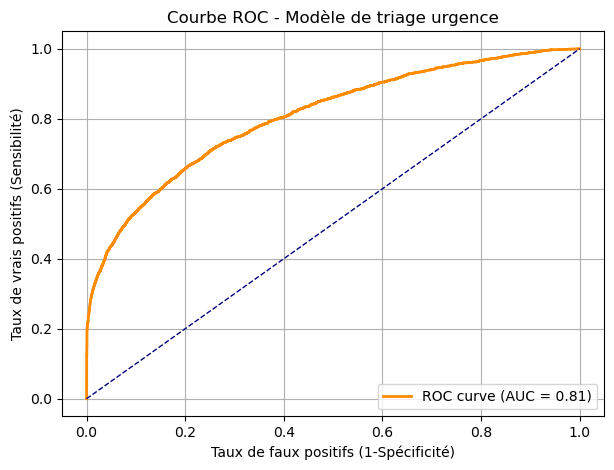

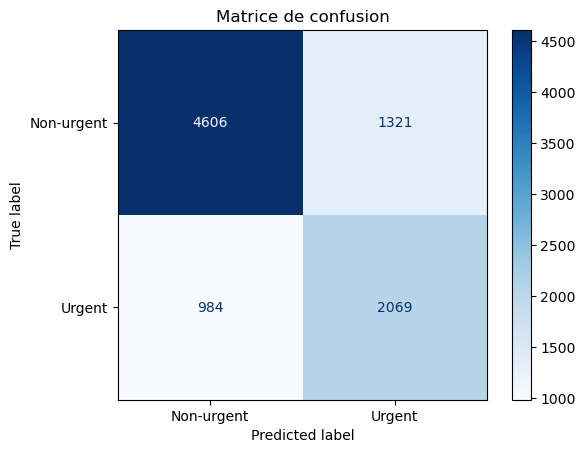

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# --- ROC CURVE ---
y_proba = pipeline.predict_proba(X_test)[:,1]  # proba "urgent"
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('Taux de faux positifs (1-Spécificité)')
plt.ylabel('Taux de vrais positifs (Sensibilité)')
plt.title('Courbe ROC - Modèle de triage urgence')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- MATRICE DE CONFUSION ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-urgent", "Urgent"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.show()


In [25]:
#TF IDF 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline  # peut rester, mais on peut aussi utiliser sklearn.pipeline.Pipeline
from textblob import TextBlob
import numpy as np

# 1. Encoder la colonne triage en 0/1
df['label'] = df['triage'].map({'non-urgent': 0, 'urgent': 1})

# 2. Préparation des features
X = df[['question_clean', 'age', 'sex']].copy()
y = df['label']

# 3. Nettoyage des colonnes
X.loc[:, 'age'] = X['age'].replace(-1, np.nan)
X.loc[:, 'age'] = X['age'].fillna(X['age'].median())
X.loc[:, 'sex'] = X['sex'].fillna('U')  # U = Unknown

# 4. Suppression des lignes sans texte vide
mask_txt = X['question_clean'].notna() & (X['question_clean'].str.strip() != "")
X = X.loc[mask_txt].copy()
y = y.loc[X.index]

# 5. Ajout de l’analyse de sentiment
X.loc[:, 'sentiment'] = X['question_clean'].apply(
    lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0
)

# 6. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

# 7. Prétraitements
preprocessor = ColumnTransformer(
    transformers=[
        ('txt', TfidfVectorizer(ngram_range=(1, 2), max_features=1000), 'question_clean'),
        ('age', StandardScaler(), ['age']),
        ('sex', OneHotEncoder(drop='first', handle_unknown='ignore'), ['sex']),
        ('sentiment', 'passthrough', ['sentiment'])
    ]
)

# 8. Pipeline sans SMOTE, avec class_weight='balanced'
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

# 9. Entraînement
pipeline.fit(X_train, y_train)

# 10. Évaluation
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.78      0.80      5927
           1       0.61      0.68      0.64      3053

    accuracy                           0.74      8980
   macro avg       0.72      0.73      0.72      8980
weighted avg       0.75      0.74      0.75      8980



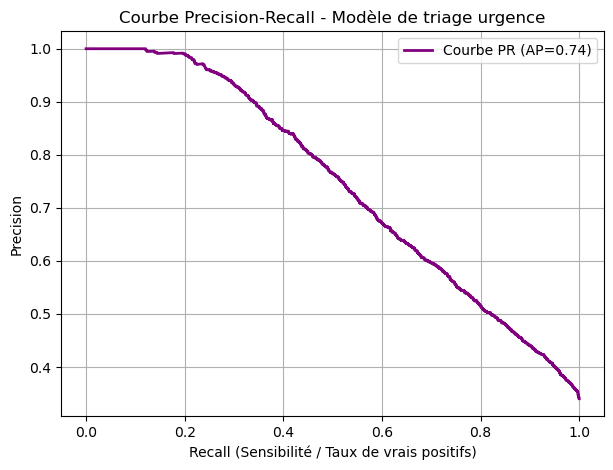

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Probabilité d'être "urgent"
y_proba = pipeline.predict_proba(X_test)[:,1]

# Calcul courbe PR
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'Courbe PR (AP={avg_prec:.2f})')
plt.xlabel('Recall (Sensibilité / Taux de vrais positifs)')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - Modèle de triage urgence')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [31]:
import joblib

joblib.dump(pipeline, "triage_pipeline.pkl")
print("✅ Pipeline sauvegardé sous triage_pipeline.pkl")


✅ Pipeline sauvegardé sous triage_pipeline.pkl
